In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
import warnings
from sklearn.svm import SVC


In [2]:
df = pd.read_csv('bank.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


The dataset has 11162 rows and 17 features

# Understanding the Dataset

Age:- Age of the customer

Job:- Job of the customer

Marital:- Marital status of the customer (Married or unmarried)

Education:- Education level of the customer

Default:- Has ever defaulted in credit

Balance:- Account Balance

Housing:- If the client has housing loan with the bank

Loan:- If the client has personal loan with the bank

Contact:- Mode of communication

Month:- Month when last contacted

Day:- Day when last contacted

Duration:- Duration of last contact in seconds

Campaign:- Number of times the person was contacted during the current campaign

pdays:- number of days since client was last contacted after the previous campaign

previous:- Number of times the person was contacted during the previous campaigns

poutcome:- outcome of the previous campaign

deposit:- does the client have a deposit with the bank

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


* Mean age in the data is 41. Min age is 18 and the maxiumum age is 95.

* Mean bank balance of customers is 1528.54. The lowest balance is -6847 and the highest balance is 81204.

In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

There are no missing values in the data.

In [6]:
df.duplicated().sum()

np.int64(0)

There are is duplicate data.

Checking the values in each column

In [7]:
for column in df.columns:
    print(f"Unique values in {column}:")
    print(df[column].unique(),"\n")

Unique values in age:
[59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89] 

Unique values in job:
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student'] 

Unique values in marital:
['married' 'single' 'divorced'] 

Unique values in education:
['secondary' 'tertiary' 'primary' 'unknown'] 

Unique values in default:
['no' 'yes'] 

Unique values in balance:
[2343   45 1270 ... 1594 2593 -134] 

Unique values in housing:
['yes' 'no'] 

Unique values in loan:
['no' 'yes'] 

Unique values in contact:
['unknown' 'cellular' 'telephone'] 

Unique values in day:
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31] 

Unique values in month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 

In [8]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [9]:
df.deposit.value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

The dataset is balanced

Lets check the distribution of the data

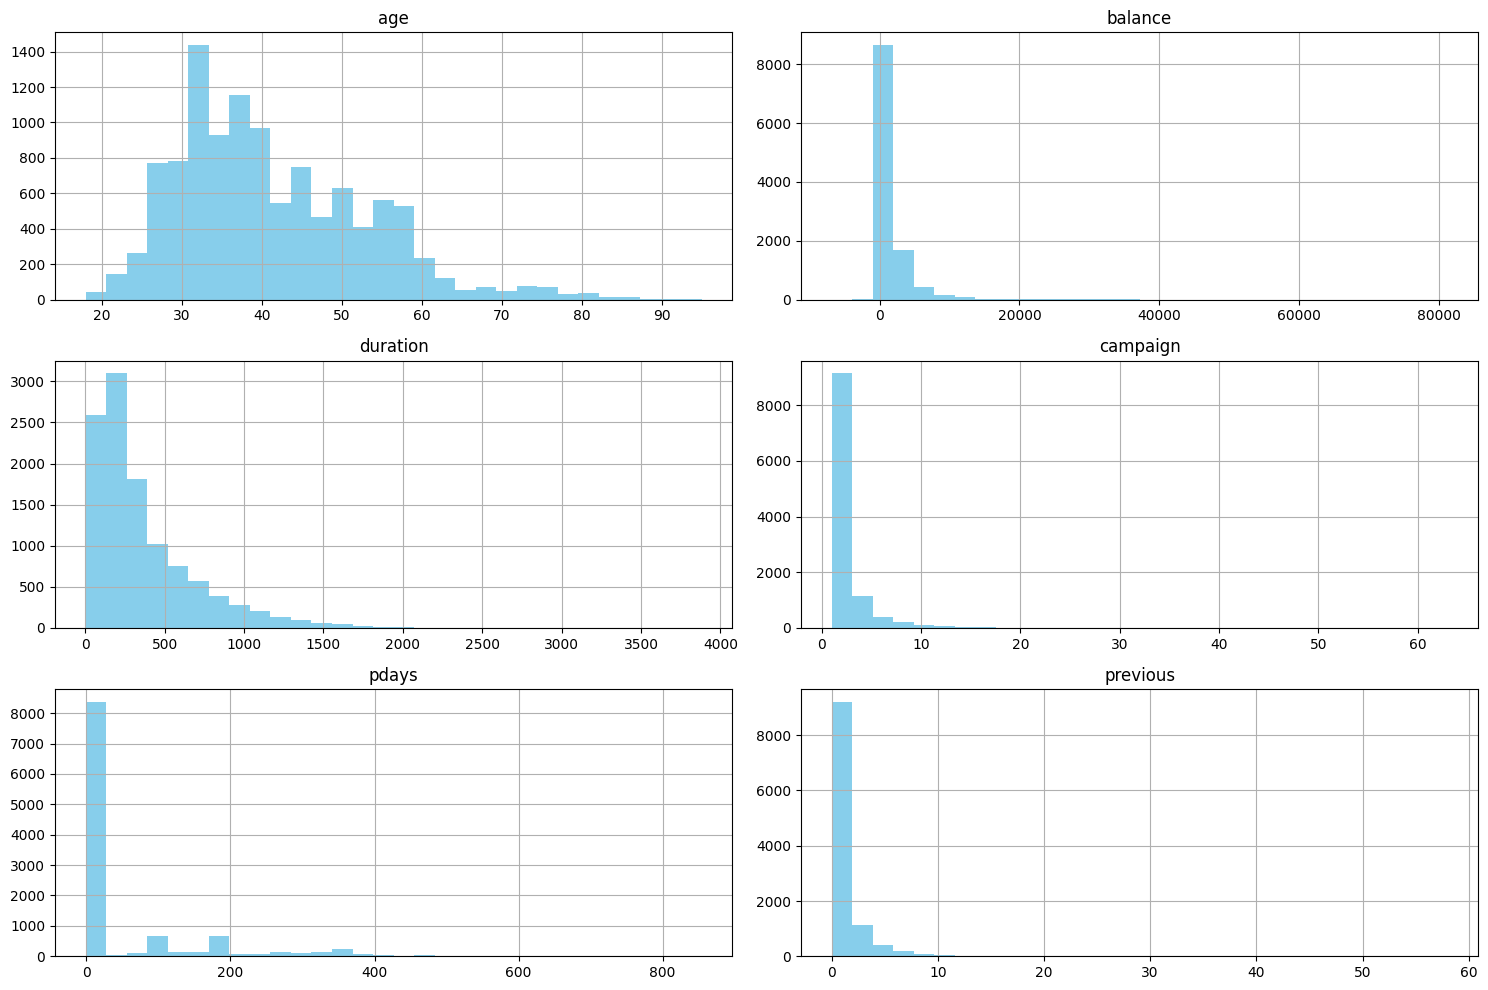

In [10]:
numerical_columns = df.select_dtypes(include=['int64']).columns
numerical_columns = numerical_columns.drop('day')

df[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
for ax in plt.gcf().axes:
    for patch in ax.patches:
        patch.set_facecolor('skyblue')
plt.show()

1. **Age**: Most people are between 20 and 40 years old, with a peak around 30. The distribution skews slightly right, with a few individuals up to around 90 years.

2. **Balance**: The distribution is highly right-skewed, with most values close to zero. A few individuals have balances that reach as high as 80,000, but such high values are rare.

3. **Duration**: This feature is also right-skewed, with the majority of contact durations being under 500 seconds.

4. **Campaign**: The majority of people have been contacted only a few times (less than 5), with a steep drop-off. There are some cases where individuals were contacted up to 20 times, but these are uncommon.

5. **Pdays**: This variable, indicating the number of days since a person was last contacted in a previous campaign, shows a concentration at zero, suggesting that many individuals were either never contacted or contacted very recently. A few have values extending up to 850 days.

6. **Previous**: Most individuals were contacted fewer than 5 times in prior campaigns, with a few individuals contacted as many as 50 times, suggesting some clients have been targeted in past campaigns much more frequently than others.

Overall, these histograms suggest that many features are highly right-skewed.

/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_31480/3031826448.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=column, ax=ax, palette=[palette[i % len(palette)]])
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_31480/3031826448.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=column, ax=ax, palette=[palette[i % len(palette)]])
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_31480/3031826448.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=column, ax=ax, palette=[pa

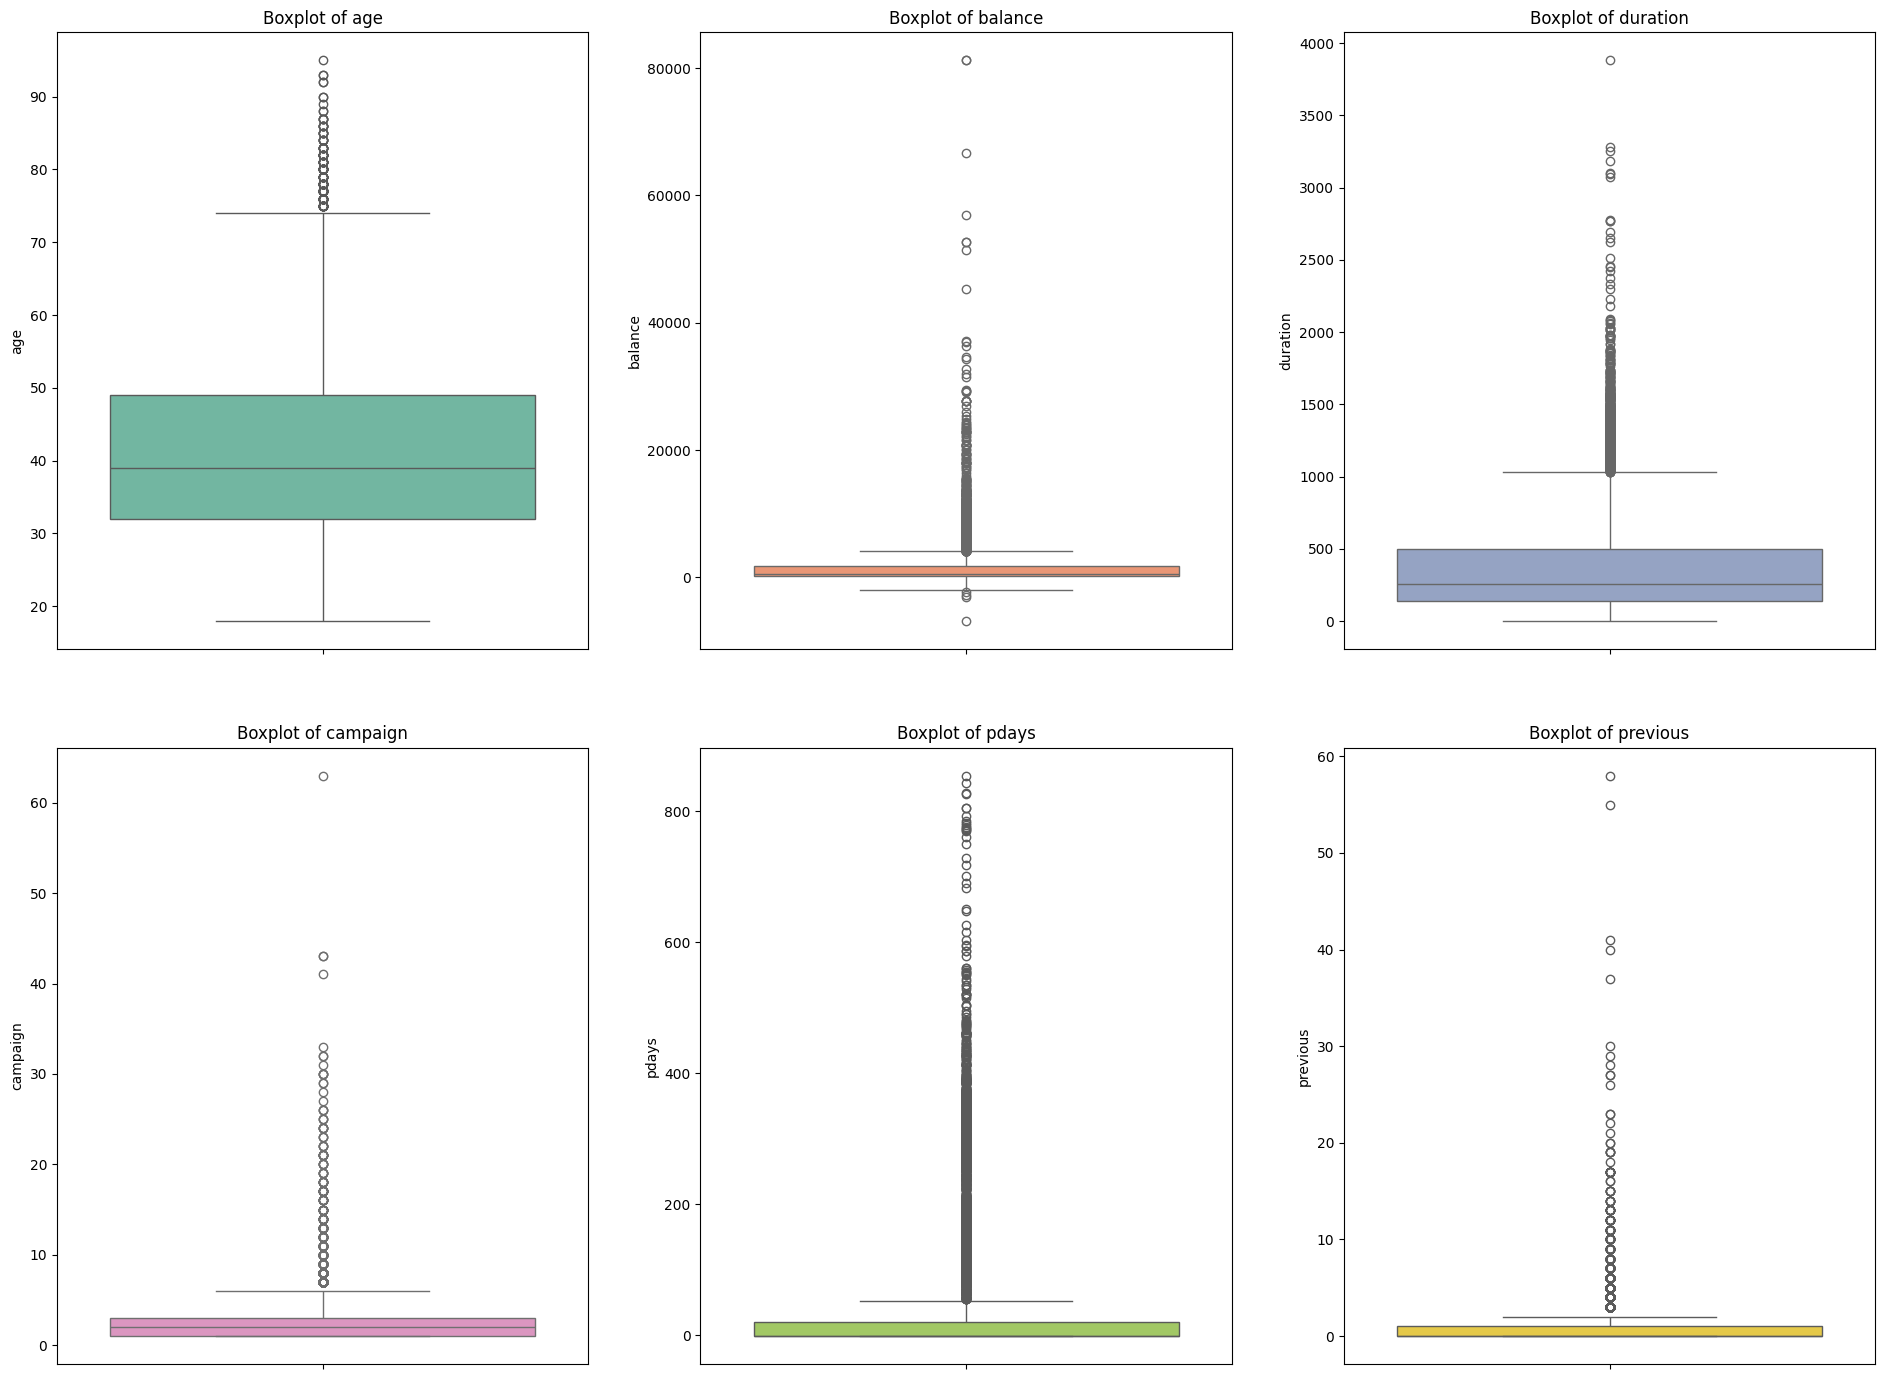

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns)//2 + len(numerical_columns)%2, figsize=(20, 15))
fig.tight_layout(pad=5.0)
palette = sns.color_palette("Set2", len(numerical_columns))

for i, (ax, column) in enumerate(zip(axes.flatten(), numerical_columns)):
    sns.boxplot(data=df, y=column, ax=ax, palette=[palette[i % len(palette)]])
    ax.set_title(f'Boxplot of {column}')
    ax.set_ylabel(column)

plt.show()

/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_31480/3079945896.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='deposit', y=column, ax=ax, palette='Set2')
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_31480/3079945896.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='deposit', y=column, ax=ax, palette='Set2')
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_31480/3079945896.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='deposit', y=column, ax=ax, palette='Set2'

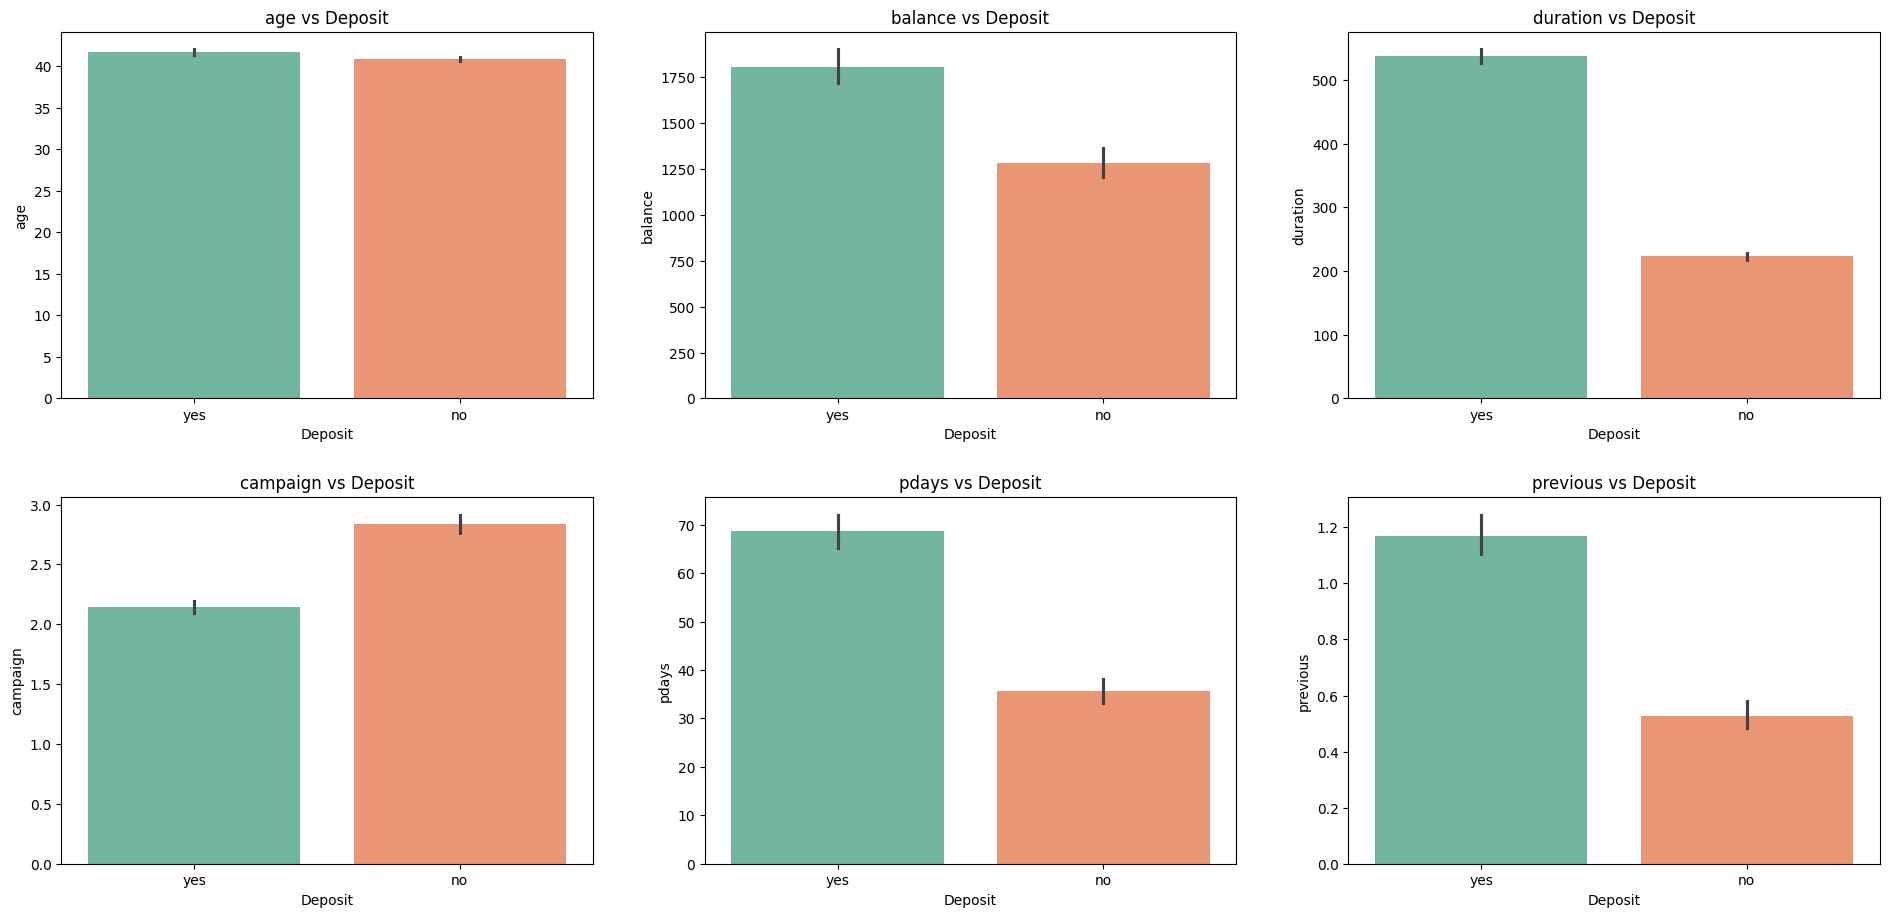

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns)//2 + len(numerical_columns)%2, figsize=(20, 10))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), numerical_columns):
    sns.barplot(data=df, x='deposit', y=column, ax=ax, palette='Set2')
    ax.set_title(f'{column} vs Deposit')
    ax.set_xlabel('Deposit')
    ax.set_ylabel(column)

plt.show()

1. **Age vs Deposit**: The average age is quite similar for both groups ("yes" and "no"), indicating that age might not have a strong impact on the likelihood of making a deposit.

2. **Balance vs Deposit**: People who made a deposit ("yes") generally have a higher average balance than those who did not ("no"), suggesting that a higher balance might be positively associated with making a deposit.

3. **Duration vs Deposit**: Duration is significantly higher for those who made a deposit. This implies that longer contact durations could be strongly associated with a successful deposit.

4. **Campaign vs Deposit**: Individuals who did not make a deposit were contacted more times on average than those who did, indicating that excessive contact attempts may reduce the chance of a deposit.

5. **Pdays vs Deposit**: The average "pdays" (days since the last contact in a previous campaign) is higher for those who made a deposit, suggesting that recent contacts in previous campaigns could negatively affect the likelihood of a deposit.

6. **Previous vs Deposit**: Those who made a deposit had slightly more prior contacts on average than those who didn’t, implying a mild association between prior engagement and successful deposits.

Overall, **balance**, **duration**, and **previous** appear to have positive associations with making a deposit, while **campaign** and **pdays** may have negative associations.

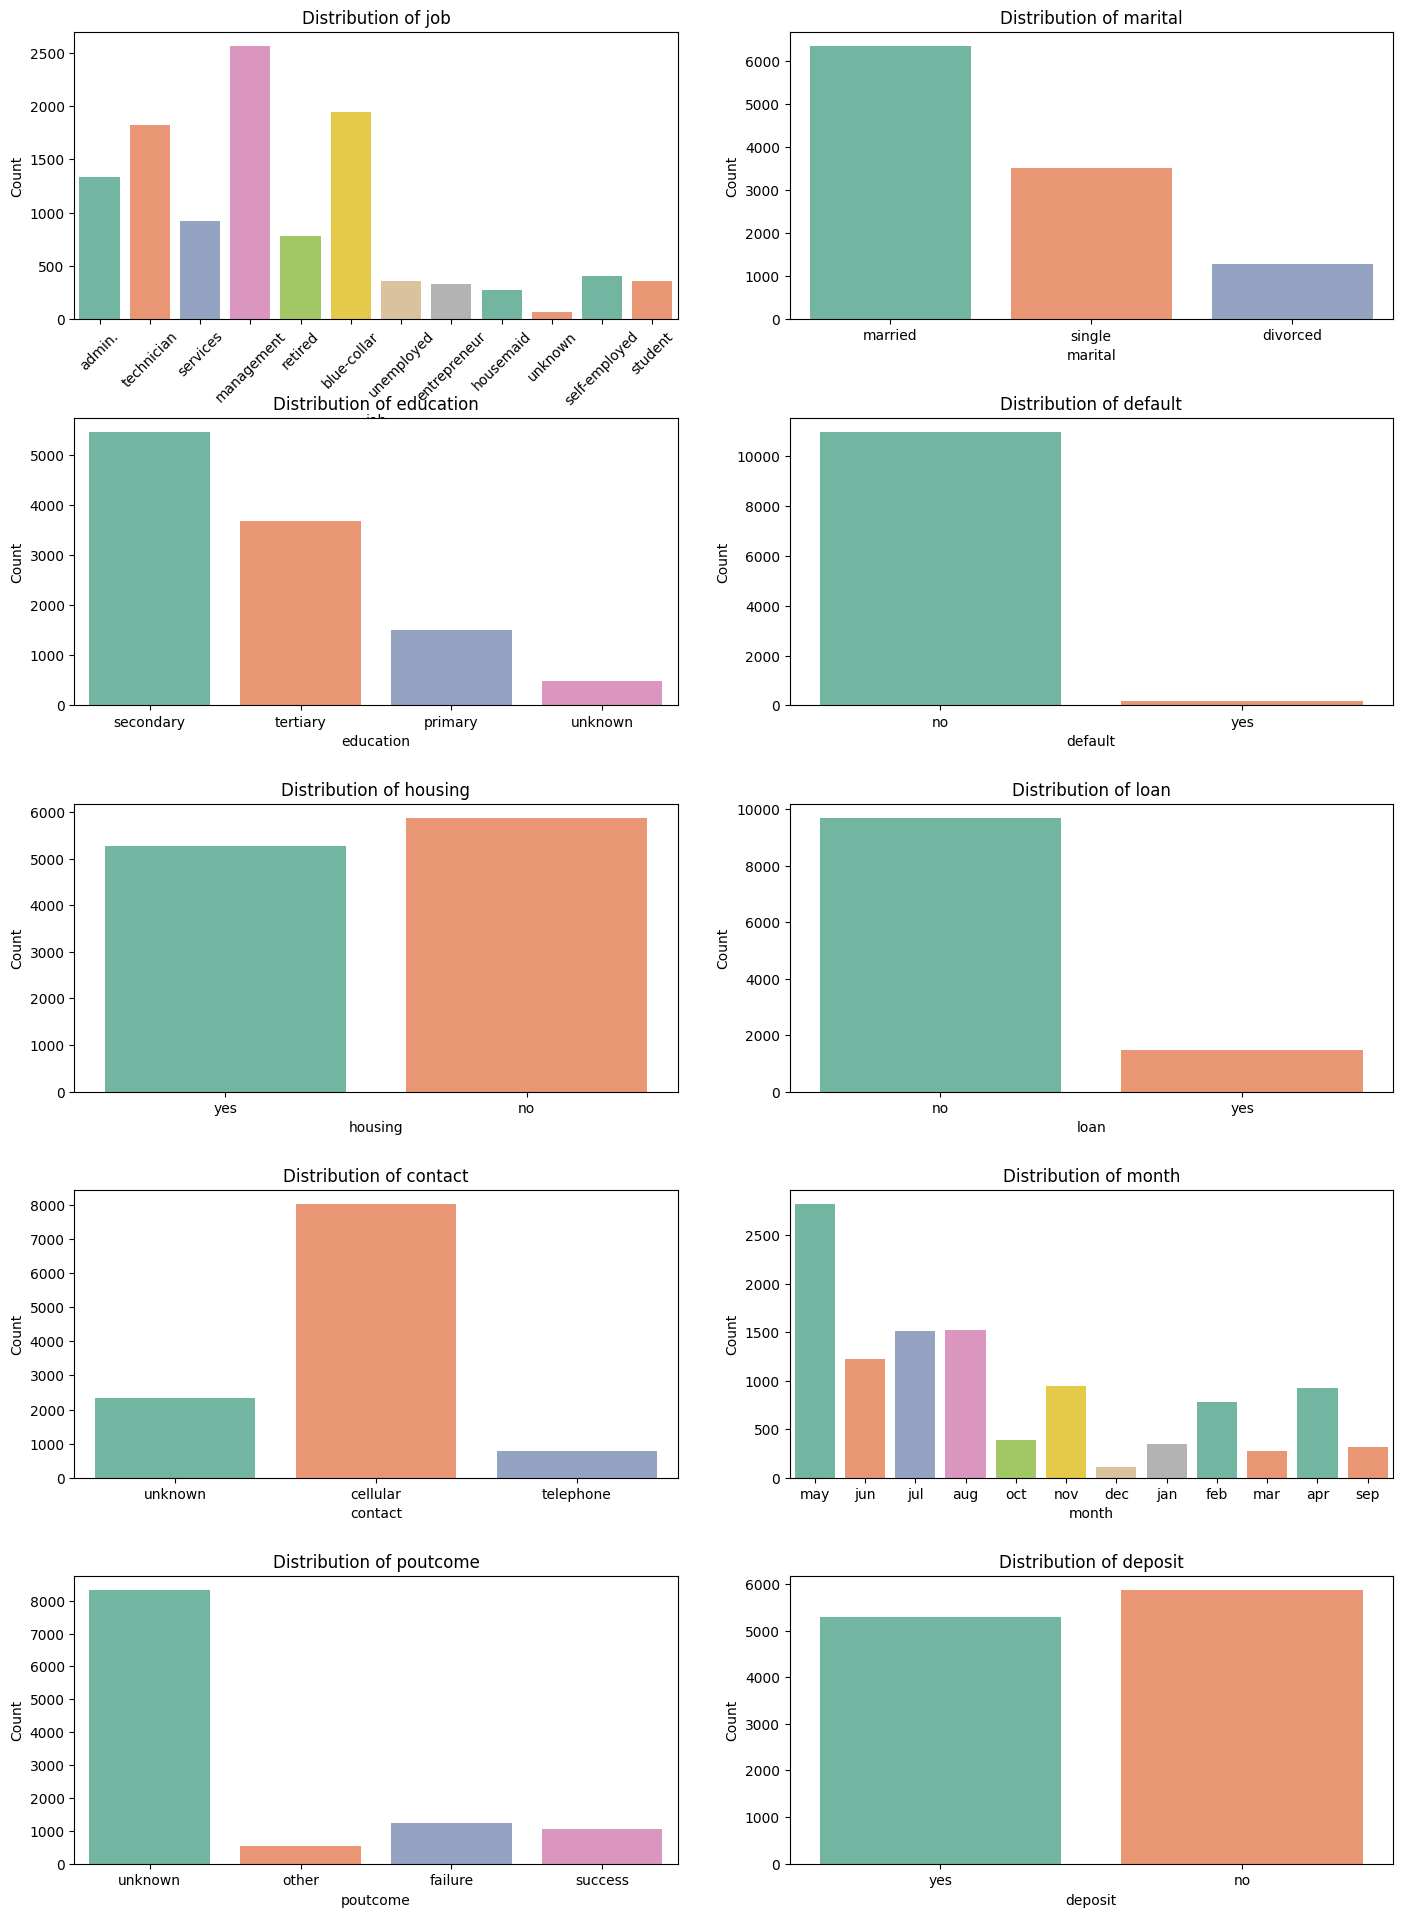

In [13]:
warnings.filterwarnings('ignore')

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
palette = sns.color_palette("Set2", len(categorical_columns))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=df, x=column, ax=ax, palette=palette)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

axes[0, 0].tick_params(axis='x', rotation=45)
plt.show()

1. **Job**: The most common jobs are blue-collar, management, and technician, while roles like student, unknown, and self-employed are less common.

2. **Marital Status**: Most individuals are married, followed by singles, and a smaller portion are divorced.

3. **Education**: Secondary education is the most common, followed by tertiary and primary education, with a small number of people in the unknown category.

4. **Default**: Very few individuals have a credit default, as the majority are marked as “no.”

5. **Housing**: The distribution between those with housing loans and those without is fairly even.

6. **Loan**: Most people do not have a personal loan, with only a small portion marked as “yes.”

7. **Contact**: Cellular contact is the most frequently used method, followed by unknown, with telephone being the least common.

8. **Month**: Most contacts occurred in May, with other active months being July, August, and October. The fewest contacts took place in March.

9. **Poutcome**: A majority of the past campaign outcomes are unknown. Among the known outcomes, failure is more common than success or other outcomes.

10. **Deposit**: The distribution shows a nearly even split between people who did and did not make a deposit.

These distributions suggest some interesting trends:
- **Job** and **marital status** likely influence other variables in the dataset given their strong frequencies.
- **Default**, **loan**, and **housing** data may have potential associations with financial stability indicators like **balance**.
- The heavy use of cellular contact suggests that this might be an effective communication method.

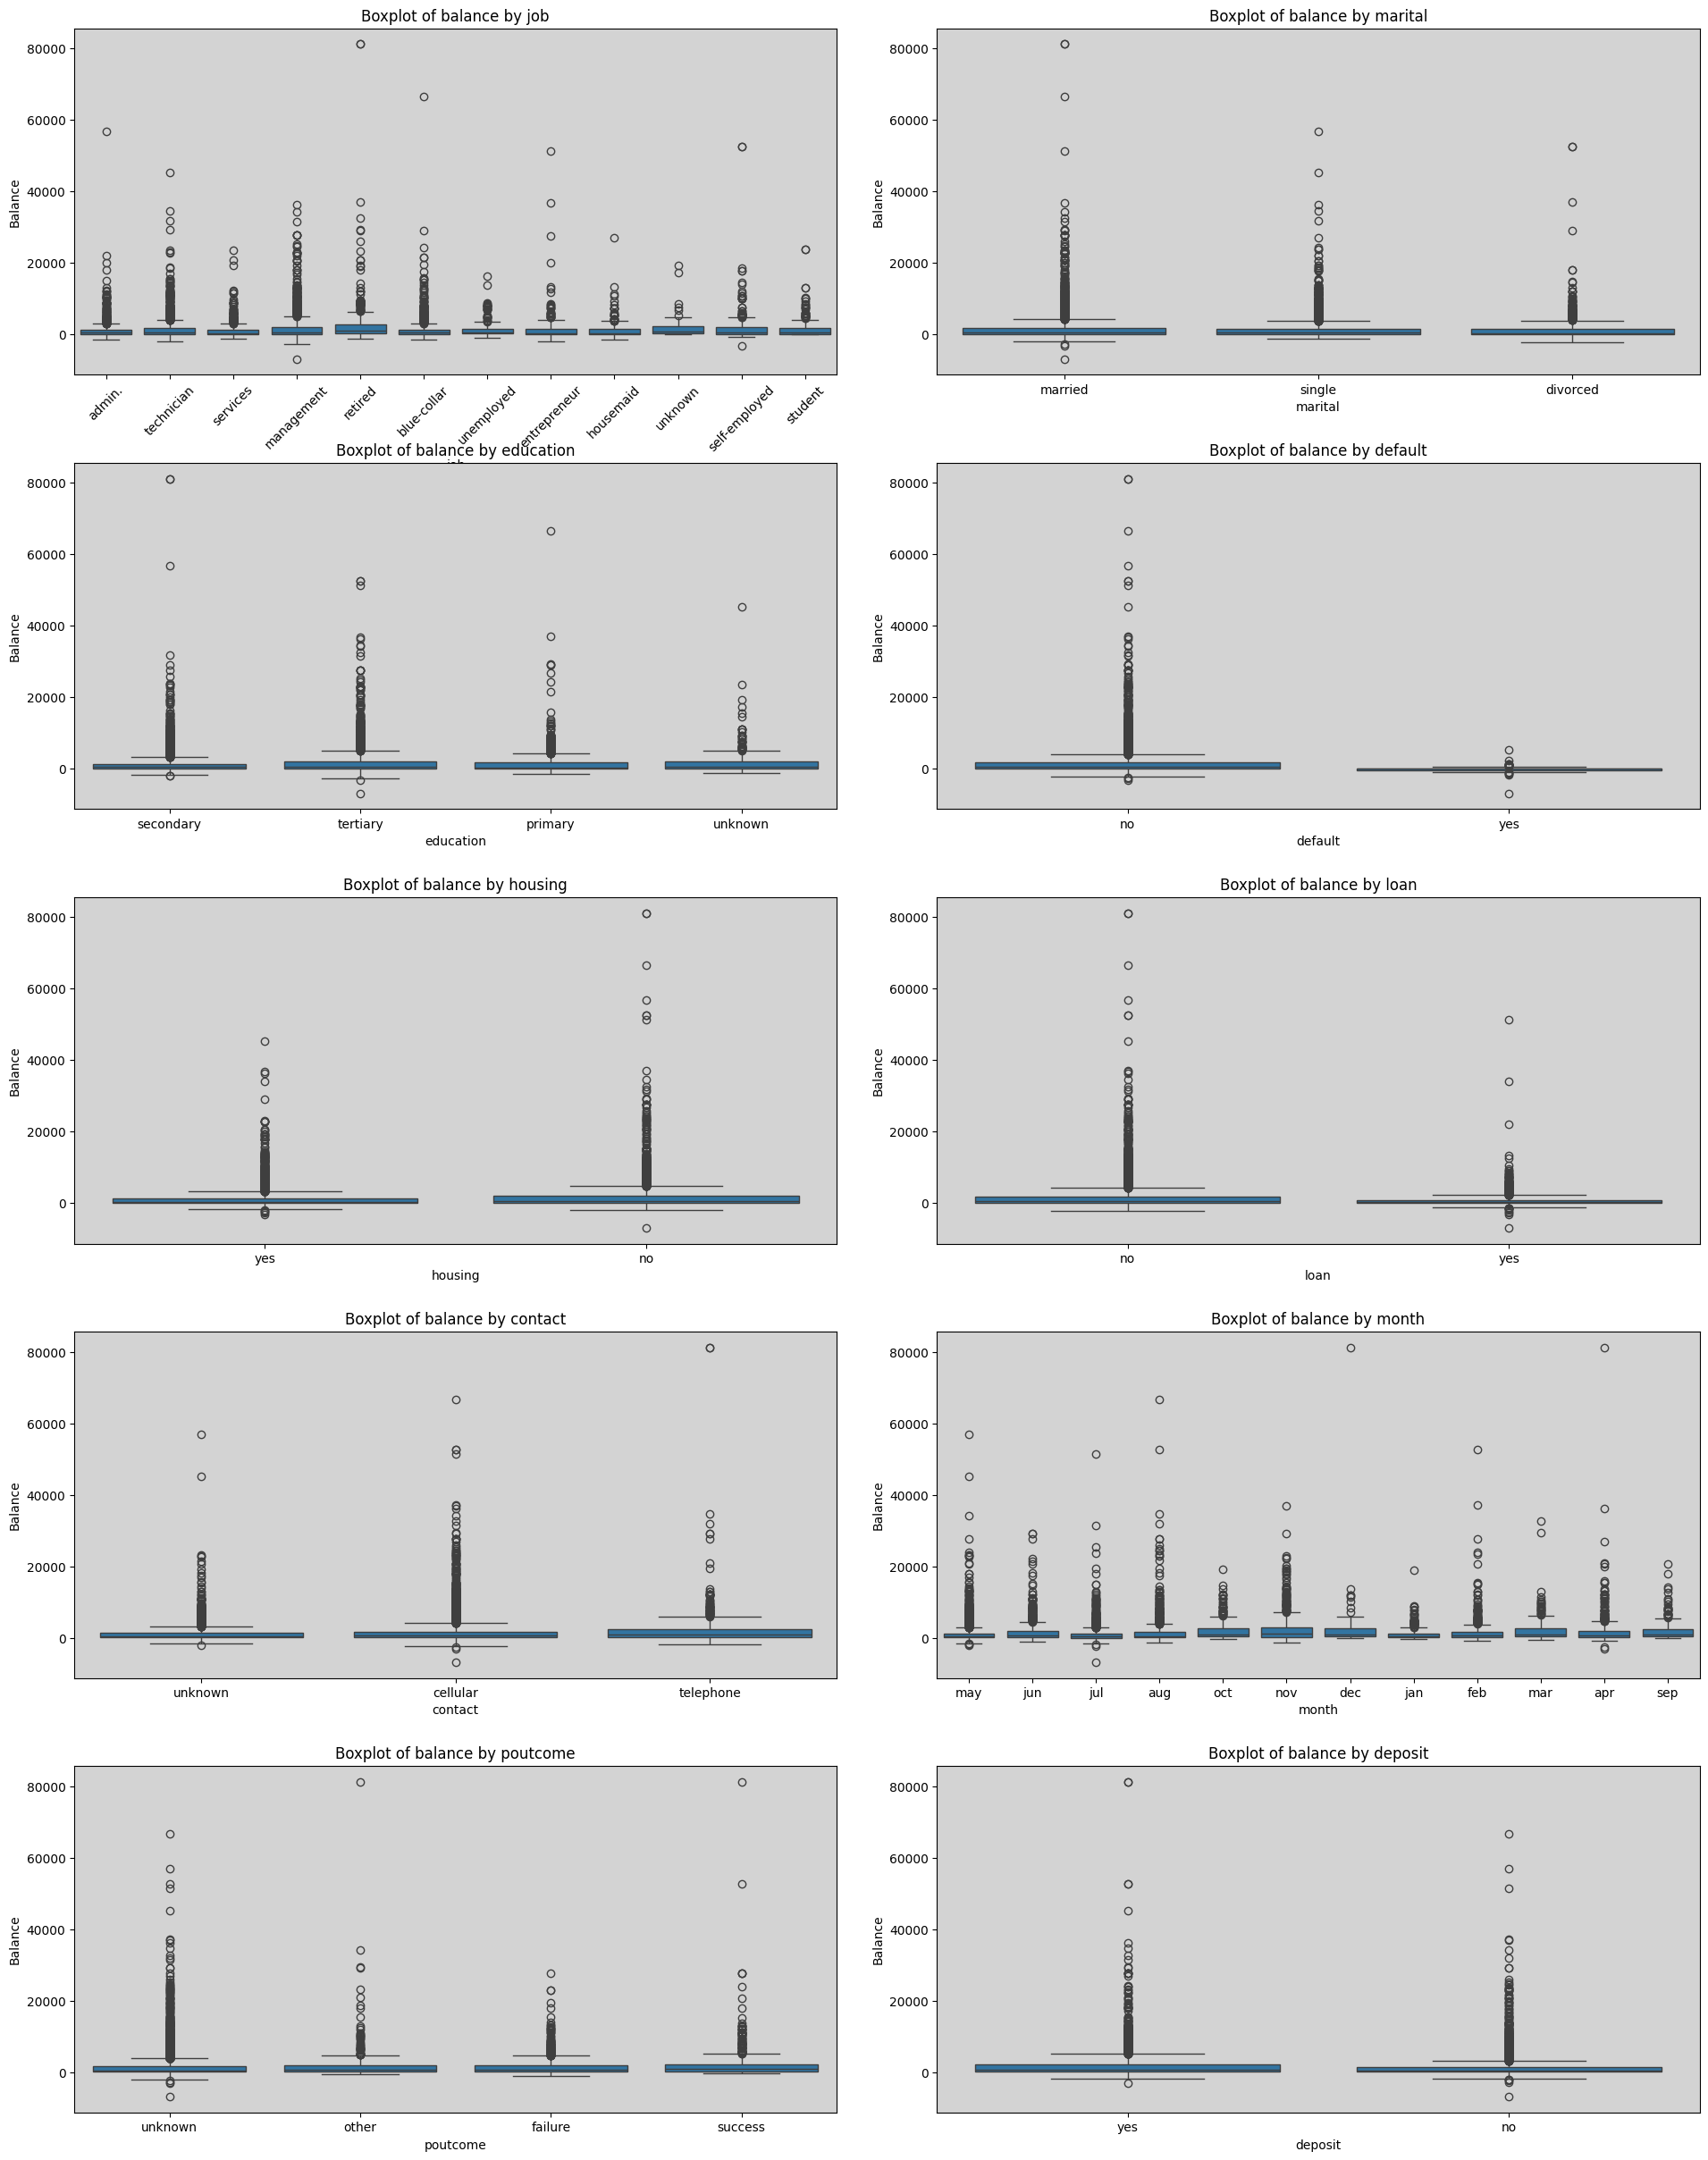

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), categorical_columns):
    sns.boxplot(data=df, x=column, y='balance', ax=ax)
    ax.set_title(f'Boxplot of balance by {column}')
    ax.set_facecolor('lightgrey')
    ax.set_xlabel(column)
    ax.set_ylabel('Balance')
    axes[0, 0].tick_params(axis='x', rotation=45)
plt.show()

1. **Job Category**:
   - Balances vary significantly across different job categories.
   - Some categories like "retired" and "management" show higher median balances compared to others like "student" or "blue-collar."
   - There are outliers in categories like "management" and "retired.

2. **Marital Status**:
   - The median balance is relatively similar across marital statuses, but there are more outliers in the "married" category.

3. **Education Level**:
   - The median balances for different education levels are quite similar.
   - There are more outliers in the "tertiary" education group, indicating some individuals have significantly higher balances.

4. **Default Status**:
   - Individuals with a "no" default status tend to have higher balances, as expected.
   - The "yes" category shows fewer outliers and lower balances overall.

5. **Housing Loan**:
   - Those without housing loans ("no") have slightly higher median balances and more outliers.
   - There are more outliers in the "yes" category.

6. **Personal Loan**:
   - Similar to housing loans, those without personal loans ("no") tend to have higher balances and more outliers.
   - The distribution is similar between both groups, but with more high-balance outliers in the "no" category.

7. **Contact Method**:
   - The balance does not significantly differ by contact method, though there are some high-balance outliers in the "telephone" category.

8. **Month of Contact**:
   - Balances show some variation across different months, with a few months like May and October showing more high-balance outliers.

9. **Previous Campaign Outcome (Poutcome)**:
   - Those with a "success" outcome tend to have higher balances than other categories.
   - There are noticeable outliers in all categories, especially in "unknown."

10. **Deposit Subscription**:
    - Individuals who did not subscribe to a deposit ("no") show slightly higher median balances.
    - There are more high-balance outliers in the "no" category.

These insights suggest that while some factors like job type and previous campaign outcomes may influence balance significantly, other factors such as marital status and education level show less variation in median balance but still include significant outliers.

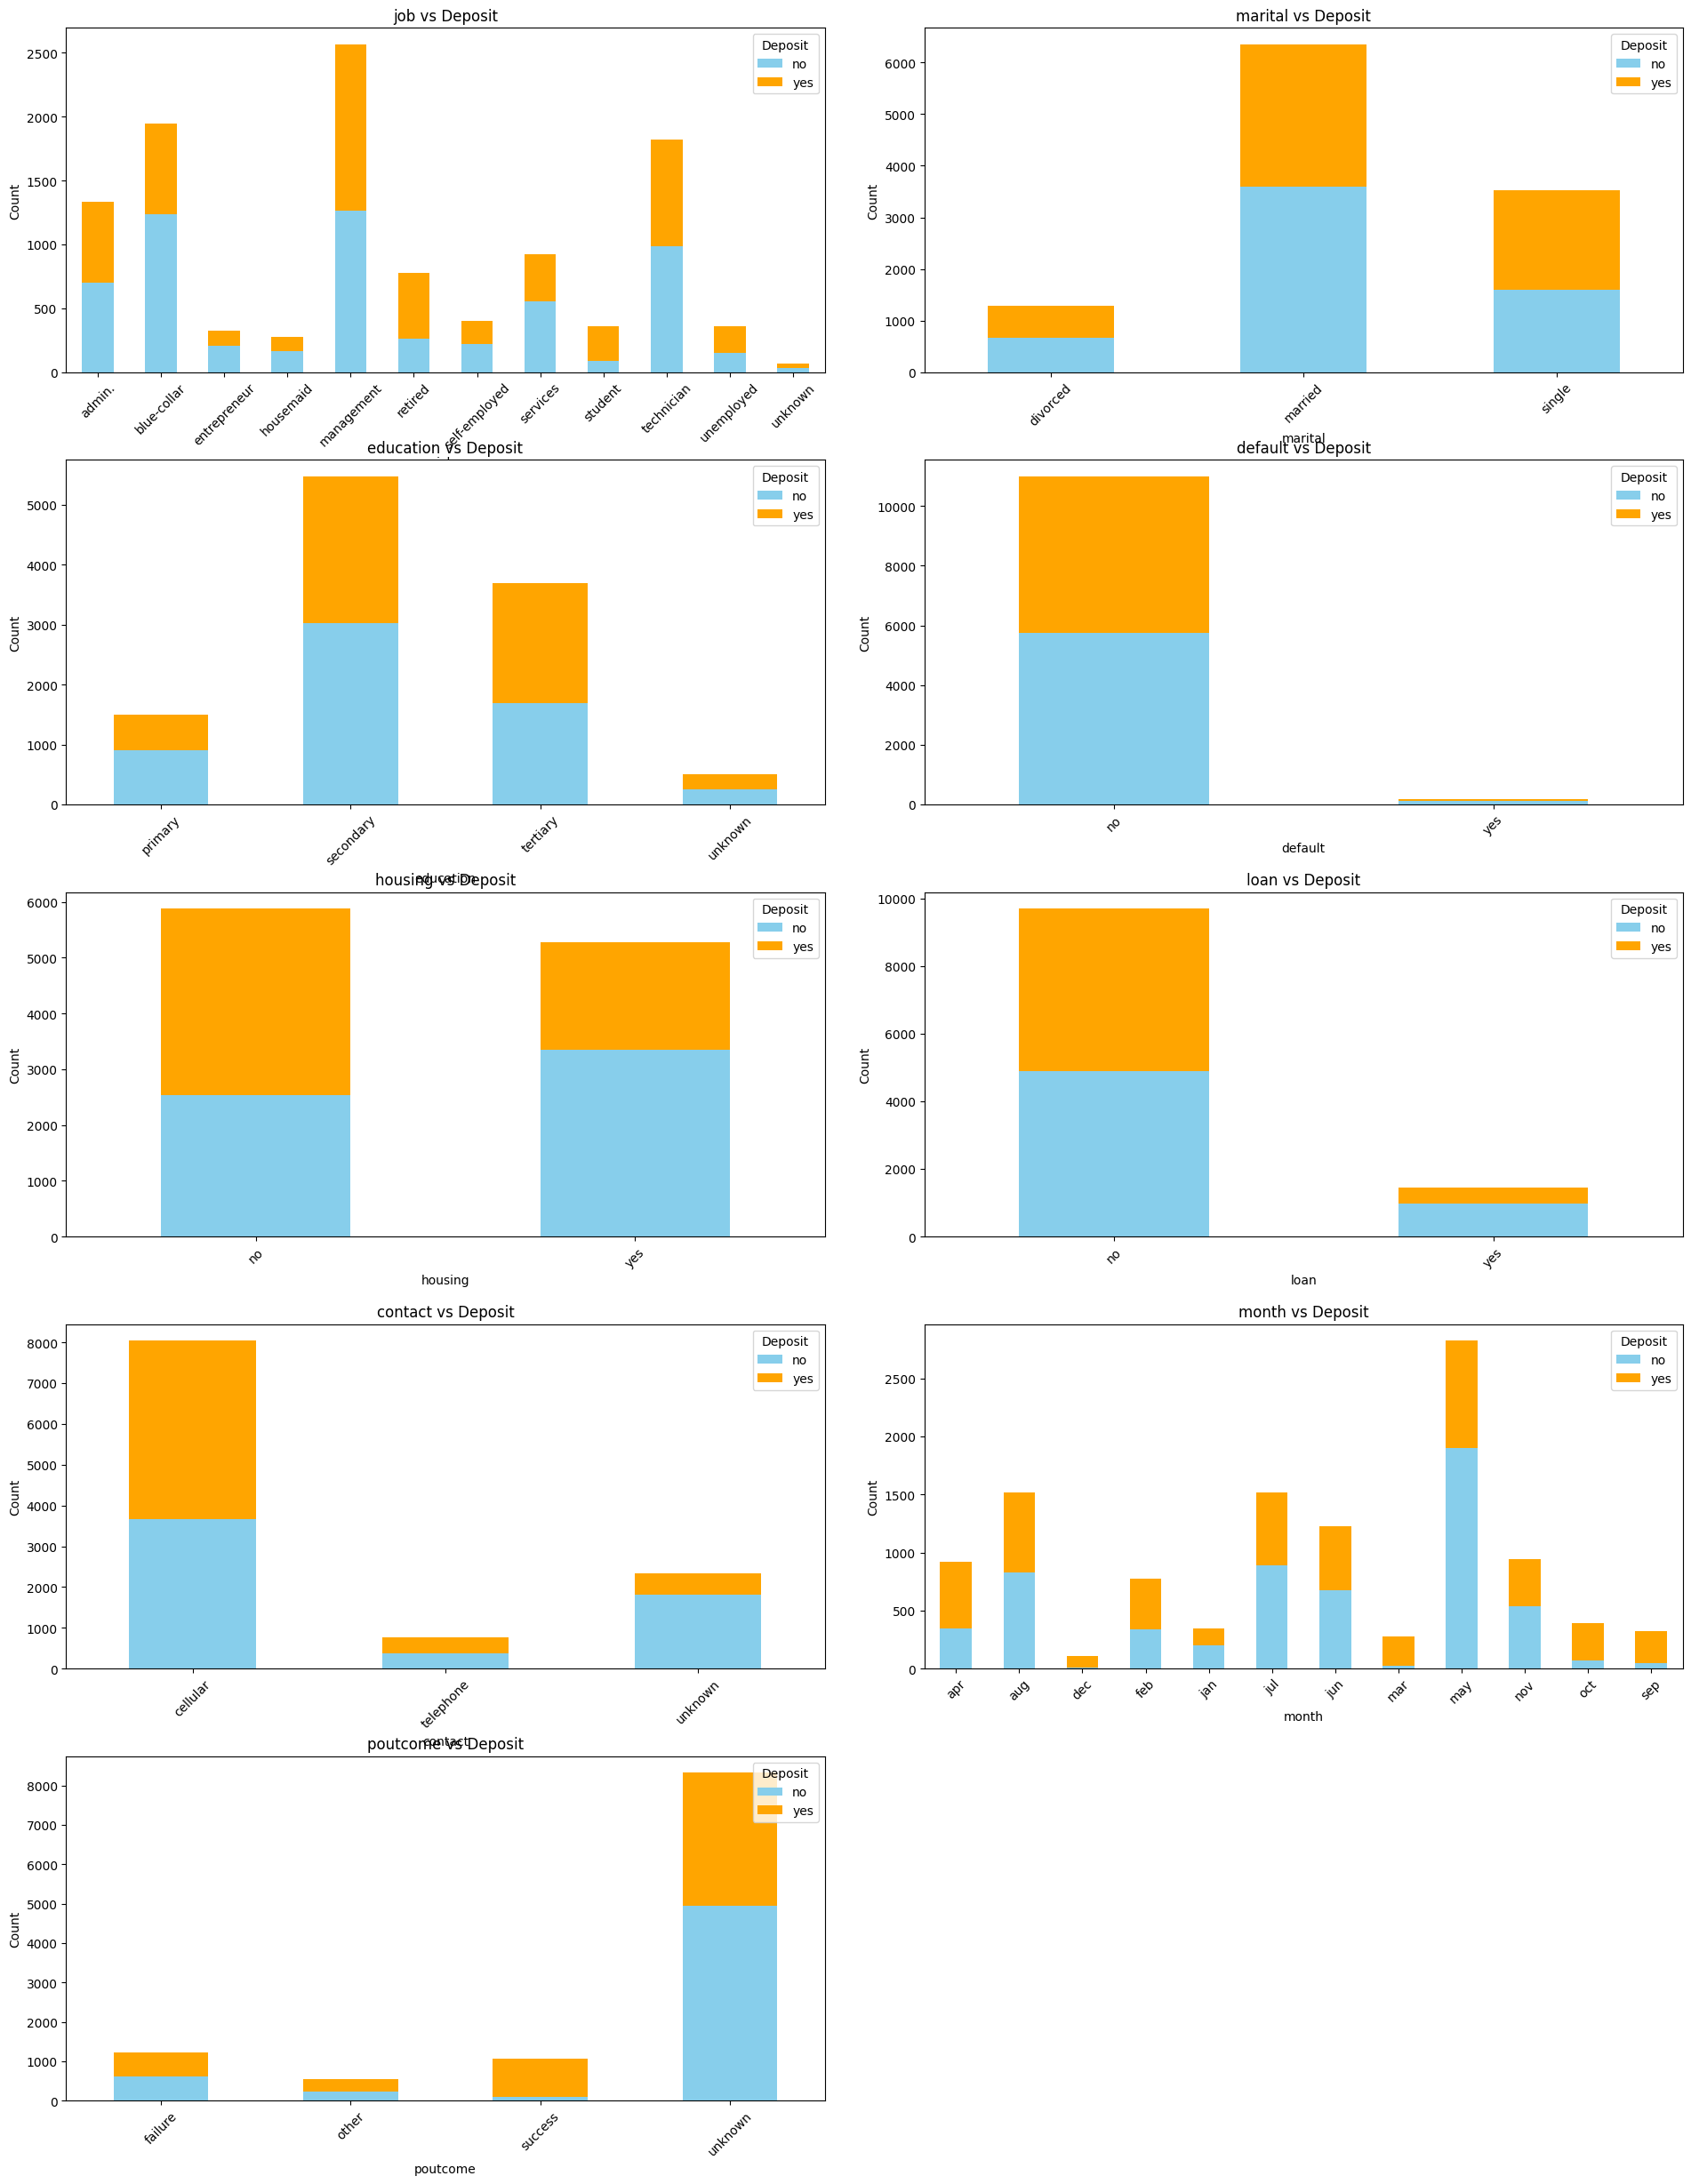

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.tight_layout(pad=5.0)
fig.delaxes(axes.flatten()[-1])
for ax, column in zip(axes.flatten(), categorical_columns):
    deposit_counts = df.groupby([column, 'deposit']).size().unstack().fillna(0)
    deposit_counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'])
    ax.set_title(f'{column} vs Deposit')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Deposit', loc='upper right')

plt.show()

1. **Job vs Deposit**:
   - Certain jobs like "management" and "retired" have higher counts of deposit subscriptions.
   - Jobs such as "student" and "blue-collar" show fewer deposits.

2. **Marital Status vs Deposit**:
   - Married individuals have a higher count of deposits compared to single or divorced individuals.

3. **Education vs Deposit**:
   - Individuals with tertiary education are more likely to subscribe to deposits, followed by those with secondary education.

4. **Default vs Deposit**:
   - Almost all deposit subscriptions come from individuals with no default history.

5. **Housing Loan vs Deposit**:
   - Those without housing loans are more likely to subscribe to deposits.

6. **Loan vs Deposit**:
   - Individuals without personal loans show a higher count of deposit subscriptions.

7. **Contact Method vs Deposit**:
   - The "cellular" contact method is associated with more deposit subscriptions compared to "telephone."

8. **Month vs Deposit**:
   - May has the highest number of deposit subscriptions, indicating possible seasonal trends.

9. **Previous Campaign Outcome (Poutcome) vs Deposit**:
   - A successful previous campaign outcome correlates with a higher likelihood of deposit subscription.

These insights suggest that factors like job type, education level, and previous campaign success significantly influence both deposit subscription likelihood and balance distribution.

Let us remove all the outliers using the IQR method

In [16]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

all_columns = df.select_dtypes(include=['int64', 'float64']).columns  
df1 = remove_outliers(df, all_columns)
df1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
10,38,admin.,single,secondary,no,100,yes,no,unknown,7,may,786,1,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,34,blue-collar,single,secondary,no,-72,yes,no,cellular,7,jul,273,5,-1,0,unknown,no
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no


After removing all the outliers, the dataset has reduced to around 6500 rows.

In [17]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

label_encoder = LabelEncoder()
df2 = df1.copy()

for column in categorical_columns:
    df2[column] = label_encoder.fit_transform(df1[column])

df2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,0,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,0,1
5,42,4,2,2,0,0,1,1,2,5,8,562,2,-1,0,0,1
8,37,9,1,1,0,1,1,0,2,6,8,608,1,-1,0,0,1
10,38,0,2,1,0,100,1,0,2,7,8,786,1,-1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,34,1,2,1,0,-72,1,0,0,7,5,273,5,-1,0,0,0
11157,33,1,2,0,0,1,1,0,0,20,0,257,1,-1,0,0,0
11158,39,7,1,1,0,733,0,0,2,16,6,83,4,-1,0,0,0
11159,32,9,2,1,0,29,0,0,0,19,1,156,2,-1,0,0,0


We are done with EDA, lets use ML algorithms to segment and categorise customers.

Splitting Train, Validation and Test data

In [18]:
X = df2.drop('deposit', axis=1)
y = df2['deposit']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3898, 16), (1300, 16), (1300, 16), (3898,), (1300,), (1300,))

In [19]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

accuracy_dt_train = (dt.predict(X_train) == y_train).mean()
accuracy_dt = (y_pred == y_test).mean()

print(f"Training Accuracy: {accuracy_dt_train}")
print(f"Test Accuracy: {round(accuracy_dt,2)}")

Training Accuracy: 1.0
Test Accuracy: 0.77


In [20]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

accuracy_rf_train = (rf.predict(X_train) == y_train).mean()
accuracy_rf_val = (y_pred == y_val).mean()

print(f"Training Accuracy: {accuracy_rf_train}")
print(f"Validation Accuracy: {round(accuracy_rf_val,2)}")

Training Accuracy: 1.0
Validation Accuracy: 0.83


In [21]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

best_params = rf_random.best_params_
best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; 

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [22]:
best_params

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [23]:
best_rf = RandomForestClassifier(**best_params, random_state=42)

best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)
y_pred_val = best_rf.predict(X_val)

accuracy_best_rf_val = (y_pred_val == y_val).mean()
accuracy_best_rf_train = (best_rf.predict(X_train) == y_train).mean()
accuracy_best_rf = (y_pred_best_rf == y_test).mean()

print(f"Training Accuracy: {round(accuracy_best_rf_train,2)}")
print(f"Validation Accuracy: {round(accuracy_best_rf_val,2)}")
print(f"Test Accuracy: {round(accuracy_best_rf,2)}")

Training Accuracy: 0.99
Validation Accuracy: 0.83
Test Accuracy: 0.85


In [24]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

accuracy_gb_train = (gb.predict(X_train) == y_train).mean()
accuracy_gb_val = (gb.predict(X_val) == y_val).mean()

print(f"Training Accuracy: {round(accuracy_gb_train,2)}")
print(f"Validation Accuracy: {round(accuracy_gb_val,2)}")

Training Accuracy: 0.87
Validation Accuracy: 0.83


In [25]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_grid = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2)

gb_grid.fit(X_train, y_train)

best_params_gb = gb_grid.best_params_
best_params_gb

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [26]:
best_gb = GradientBoostingClassifier(**best_params_gb, random_state=42)

best_gb.fit(X_train, y_train)
y_pred_best_gb = best_gb.predict(X_test)
y_pred_val_gb = best_gb.predict(X_val)

accuracy_best_gb_val = (y_pred_val_gb == y_val).mean()
accuracy_best_gb_train = (best_gb.predict(X_train) == y_train).mean()
accuracy_best_gb_test = (y_pred_best_gb == y_test).mean()

print(f"Training Accuracy: {round(accuracy_best_gb_train,2)}")
print(f"Validation Accuracy: {round(accuracy_best_gb_val,2)}")
print(f"Test Accuracy: {round(accuracy_best_gb_test,2)}")

Training Accuracy: 0.94
Validation Accuracy: 0.83
Test Accuracy: 0.86


In [27]:
svm = SVC(random_state=42)

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

accuracy_svm_train = accuracy_score(y_train, svm.predict(X_train))
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)

print(f"Training Accuracy: {round(accuracy_svm_train,2)}")
print(f"Test Accuracy: {round(accuracy_svm_test,2)}")

Training Accuracy: 0.76
Test Accuracy: 0.76


In [28]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)

y_pred_val_xgb = xgb.predict(X_val)

accuracy_xgb_val = (y_pred_val_xgb == y_val).mean()
accuracy_xgb_train = (xgb.predict(X_train) == y_train).mean()

print(f"Training Accuracy: {round(accuracy_xgb_train,2)}")
print(f"Validation Accuracy: {round(accuracy_xgb_val,2)}")

Training Accuracy: 1.0
Validation Accuracy: 0.84


In [29]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

xgb_random.fit(X_train, y_train)

best_params_xgb = xgb_random.best_params_
best_params_xgb

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=400, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.3

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=500, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=500, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, min_child_weight=4, n_estimators=300, subsample=0.8; total time=   0.1s


{'subsample': 0.7,
 'n_estimators': 400,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [30]:
best_params_xgb

{'subsample': 0.7,
 'n_estimators': 400,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [31]:
best_xgb = XGBClassifier(**best_params_gb,random_state=42)

best_xgb.fit(X_train, y_train)

y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_val_xgb = best_xgb.predict(X_val)

accuracy_best_xgb_train = (best_xgb.predict(X_train) == y_train).mean()
accuracy_best_xgb_val = (y_pred_val_xgb == y_val).mean()
accuracy_best_xgb_test = (y_pred_best_xgb == y_test).mean()

print(f"Training Accuracy: {round(accuracy_best_xgb_train,2)}")
print(f"Validation Accuracy: {round(accuracy_best_xgb_val,2)}")
print(f"Test Accuracy: {round(accuracy_best_xgb_test,2)}")

Training Accuracy: 0.91
Validation Accuracy: 0.83
Test Accuracy: 0.85


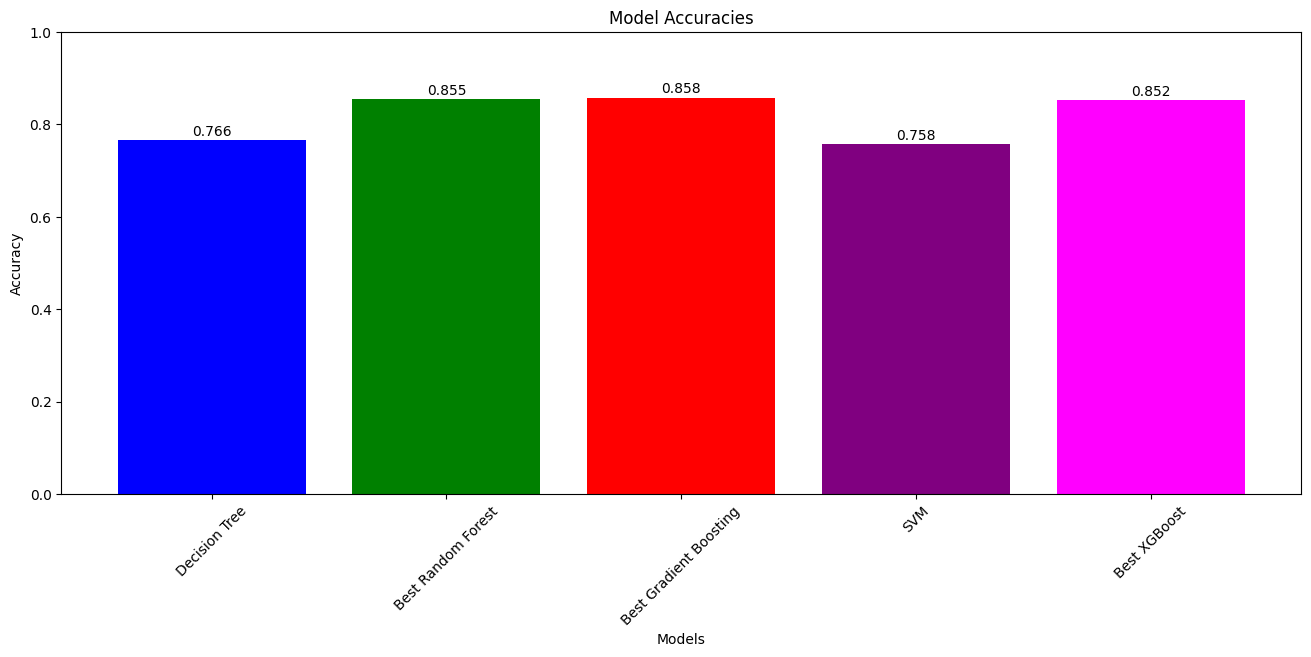

In [32]:
models = ['Decision Tree', 'Best Random Forest', 'Best Gradient Boosting', 'SVM','Best XGBoost']
accuracies = [accuracy_dt, accuracy_best_rf, accuracy_best_gb_test, accuracy_svm_test, accuracy_best_xgb_test]

plt.figure(figsize=(16, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'magenta'])

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
    
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)
plt.show()

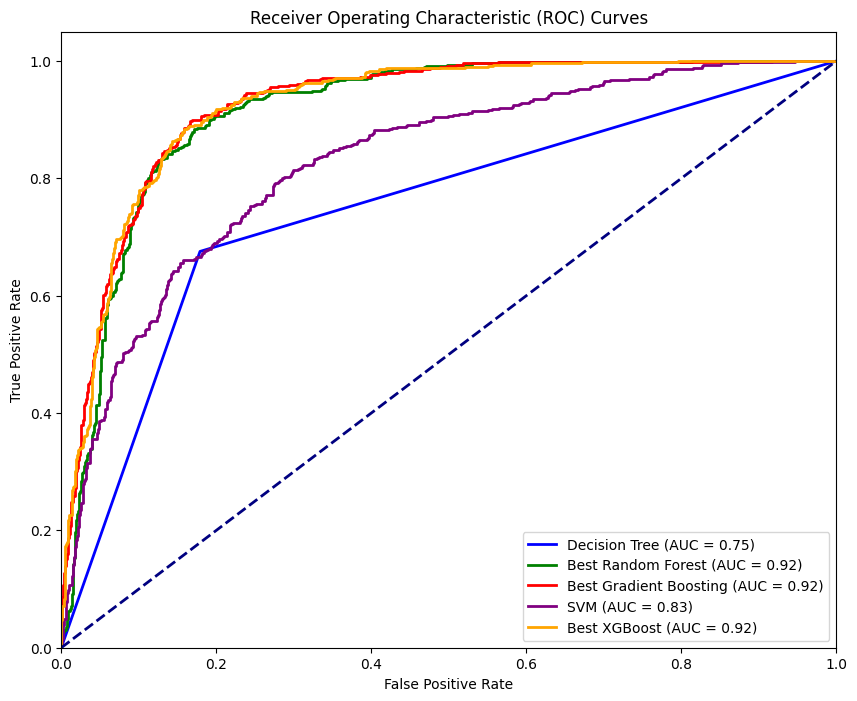

In [36]:
from sklearn.metrics import roc_curve, auc

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt.predict_proba(X_test)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
roc_auc_best_rf = auc(fpr_best_rf, tpr_best_rf)

fpr_best_gb, tpr_best_gb, _ = roc_curve(y_test, best_gb.predict_proba(X_test)[:, 1])
roc_auc_best_gb = auc(fpr_best_gb, tpr_best_gb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.decision_function(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_best_xgb, tpr_best_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
roc_auc_best_xgb = auc(fpr_best_xgb, tpr_best_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_best_rf, tpr_best_rf, color='green', lw=2, label=f'Best Random Forest (AUC = {roc_auc_best_rf:.2f})')
plt.plot(fpr_best_gb, tpr_best_gb, color='red', lw=2, label=f'Best Gradient Boosting (AUC = {roc_auc_best_gb:.2f})')
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_best_xgb, tpr_best_xgb, color='orange', lw=2, label=f'Best XGBoost (AUC = {roc_auc_best_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

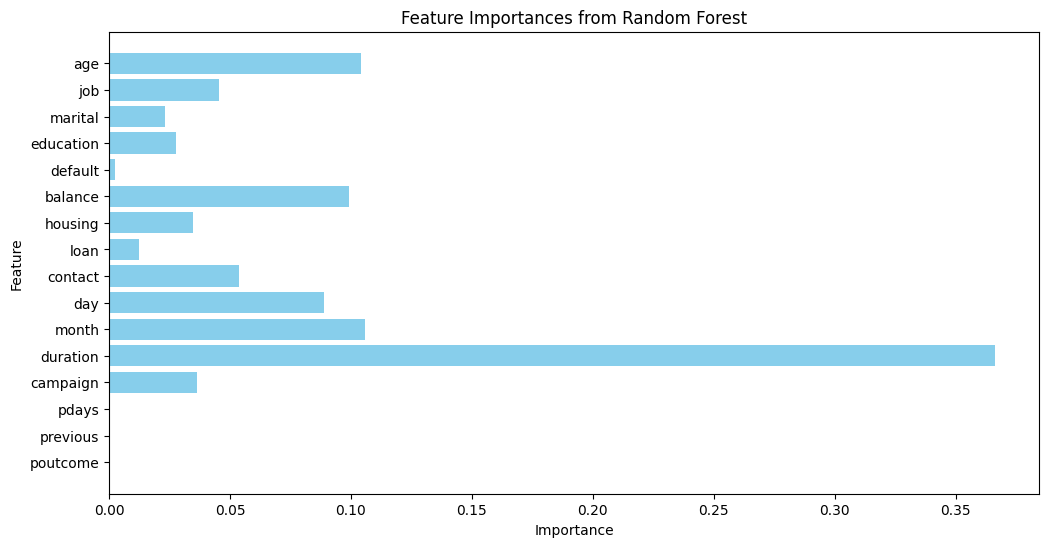

      Feature  Importance
11   duration    0.366210
10      month    0.105762
0         age    0.103990
5     balance    0.099360
9         day    0.088754
8     contact    0.053693
1         job    0.045491
12   campaign    0.036507
6     housing    0.034627
3   education    0.027496
2     marital    0.023115
7        loan    0.012502
4     default    0.002492
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


In [33]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

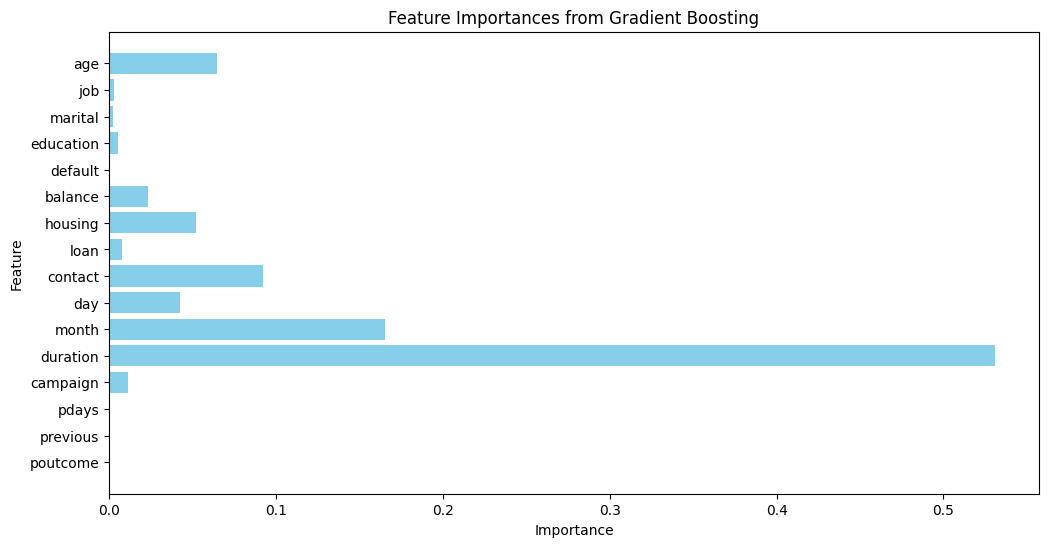

      Feature  Importance
11   duration    0.530725
10      month    0.165234
8     contact    0.092218
0         age    0.064570
6     housing    0.052233
9         day    0.042230
5     balance    0.023203
12   campaign    0.011346
7        loan    0.007496
3   education    0.005497
1         job    0.002704
2     marital    0.002544
4     default    0.000000
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


In [34]:
importances_gb = gb.feature_importances_

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances_gb, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

feature_importances_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

print(feature_importances_gb)

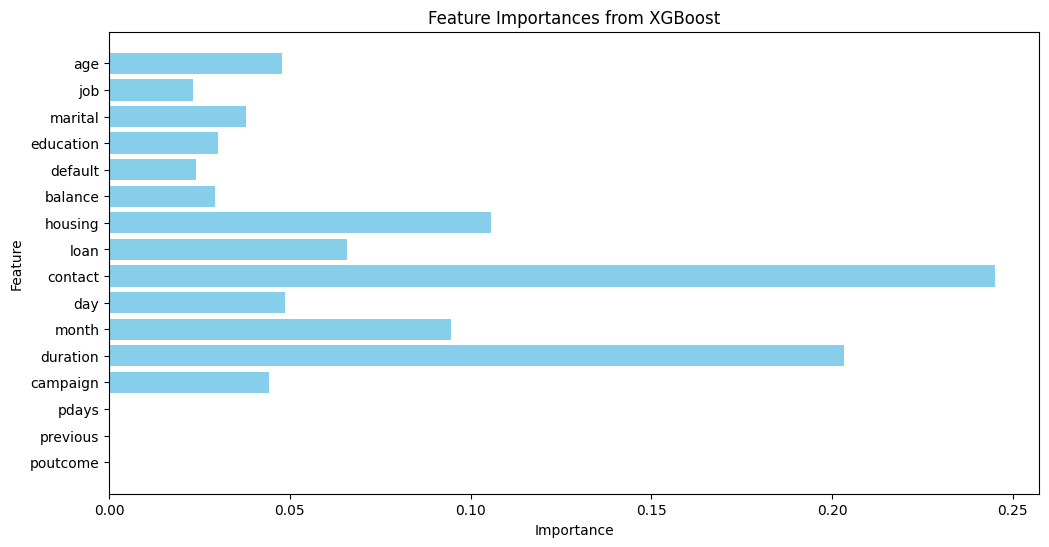

      Feature  Importance
8     contact    0.245018
11   duration    0.203277
6     housing    0.105760
10      month    0.094494
7        loan    0.065884
9         day    0.048754
0         age    0.047895
12   campaign    0.044333
2     marital    0.037773
3   education    0.030229
5     balance    0.029212
4     default    0.024069
1         job    0.023302
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


In [35]:
importances_xgb = best_xgb.feature_importances_

plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances_xgb, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost')
plt.gca().invert_yaxis()
plt.show()

feature_importances_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importance', ascending=False)

print(feature_importances_xgb)